In [115]:
# Import packages
import pandas as pd
import seaborn as sns
import sqlite3 as sq
import matplotlib.pyplot as plt
%matplotlib inline

# Add extra relevant packages below as needed: 
import shutil
import numpy as np
import os
import re

# Non-SQL Databases

### TMDB

In [2]:
db = pd.read_csv('zippedData/tmdb.movies.csv.gz')
db['genre_ids'].replace([''], np.nan, inplace=True)

db.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
genre_ids = db['genre_ids'].tolist()
genre_ids
counter = 0
genre_list = []
for list_ in genre_ids:
    temp_item = genre_ids[counter].strip('][').split(', ')
    genre_list.append(temp_item)
    counter += 1

### TN DB

In [5]:
tn_budget_raw = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_budget_raw.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### BOM DB

In [6]:
bom_budget_raw = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
bom_budget_raw.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Combining tables

In [7]:
result = pd.merge(tn_budget_raw, db, left_on='movie', right_on='original_title',how='inner')
result.drop(columns=['id_x','Unnamed: 0','genre_ids','id_y','original_title','title'], inplace=True)
result

,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,release_date_y,vote_average,vote_count
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",en,26.526,2009-12-18,7.4,18676
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",en,30.579,2011-05-20,6.4,8571
2,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",en,44.383,2015-05-01,7.3,13457
3,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",en,80.773,2018-04-27,8.3,13948
4,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",en,34.953,2017-11-17,6.2,7510
...,...,...,...,...,...,...,...,...,...,...
2311,"Sep 1, 2015",Exeter,"$25,000",$0,"$489,792",en,5.934,2015-03-26,4.7,121
2312,"Apr 21, 2015",Ten,"$25,000",$0,$0,en,1.575,2014-03-28,5.4,5
2313,"Dec 31, 2014",Dry Spell,"$22,000",$0,$0,en,0.600,2013-02-14,6.0,1
2314,"Jan 4, 2013",All Superheroes Must Die,"$20,000",$0,$0,en,2.078,2013-01-04,3.9,19


# IMDB SQL Database

In [8]:
# Unzip IMDB SQL to new folder repository
import zipfile
with zipfile.ZipFile("zippedData/im.db.zip", 'r') as zip_ref:
    zip_ref.extractall("temp/IMDB_sql")
    
db_file = 'temp/IMDB_sql/im.db'

In [19]:
# Initializing imdb SQL database
# Create a SQL connection to our SQLite database
con = sq.connect(db_file)


## Connection test and reference
genre_reviews = pd.read_sql(""" SELECT genres, primary_title, start_year
                
                FROM movie_basics
                LEFT JOIN movie_ratings ON movie_ratings.movie_id = movie_basics.movie_id
                JOIN movie_akas ON movie_akas.movie_id = movie_basics.movie_id
                WHERE start_year >= 2015 and region = 'US'
                ORDER BY averagerating DESC

""", con)

genre_reviews.dropna(inplace = True)
genre_reviews

,genres,primary_title,start_year
0,Documentary,Revolution Food,2015
1,Drama,Dog Days in the Heartland,2017
2,Documentary,All Around Us,2019
3,"Documentary,History",Ellis Island: The Making of a Master Race in A...,2018
4,Documentary,Fly High: Story of the Disc Dog,2019
...,...,...,...
23447,"Drama,Horror,Thriller",Miss Yo Face,2017
23448,Documentary,Conway Pride,2018
23449,"Comedy,Romance",Straight Up,2019
23450,Drama,The Journey Ahead,2018


In [42]:
# DO THINGS
comb_data = pd.merge(result, genre_reviews, left_on='movie', right_on='primary_title',how='inner')
comb_data.drop(columns=['primary_title', 'release_date_x','release_date_y'], inplace=True)
comb_data.drop_duplicates(subset=['movie'], inplace=True, ignore_index=True)

comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year
0,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015
1,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018
2,Justice League,"$300,000,000","$229,024,295","$655,945,209",en,34.953,6.2,7510,"Action,Adventure,Fantasy",2017
3,Spectre,"$300,000,000","$200,074,175","$879,620,923",en,30.318,6.4,6719,"Action,Adventure,Thriller",2015
4,Solo: A Star Wars Story,"$275,000,000","$213,767,512","$393,151,347",en,29.502,6.6,3838,"Action,Adventure,Fantasy",2018
...,...,...,...,...,...,...,...,...,...,...
649,Happy 40th,"$35,000",$0,$0,en,0.600,6.0,2,Drama,2015
650,Krisha,"$30,000","$144,822","$144,822",en,0.600,9.0,1,Drama,2015
651,Emily,"$27,000","$3,547","$3,547",en,0.600,7.0,1,Drama,2017
652,Exeter,"$25,000",$0,"$489,792",en,5.934,4.7,121,"Horror,Mystery,Thriller",2015


In [43]:
# Convert production budgets into ints
comb_data['production_budget'] = comb_data['production_budget'].str.strip('$')
comb_data['production_budget'] = comb_data['production_budget'].str.replace(',','')
comb_data['production_budget'] = comb_data['production_budget'].astype(int)

In [45]:
#Convert domestic gross into ints
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.strip('$')
comb_data['domestic_gross'] = comb_data['domestic_gross'].str.replace(',','')
comb_data['domestic_gross'] = comb_data['domestic_gross'].astype(int)

In [46]:
# Convert worldwide gross into ints
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.strip('$')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].str.replace(',','')
comb_data['worldwide_gross'] = comb_data['worldwide_gross'].astype(int)

In [47]:
# Sort by worldwide gross
comb_data.sort_values(by="worldwide_gross", ascending=False, inplace=True, ignore_index=True)

comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015
3,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015
4,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018
...,...,...,...,...,...,...,...,...,...,...
649,Checkmate,1500000,0,0,en,3.764,4.2,20,"Action,Crime,Thriller",2015
650,Bleeding Hearts,1200000,0,0,en,0.600,6.0,2,Horror,2015
651,The Wicked Within,1200000,0,0,en,2.897,4.4,28,Horror,2015
652,Hush,1000000,0,0,en,0.600,6.0,1,"Horror,Thriller",2016


In [49]:
# Removing movies that made no money
comb_data = comb_data[(comb_data['worldwide_gross'] > 25000)]

comb_data

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015
3,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015
4,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018
...,...,...,...,...,...,...,...,...,...,...
585,The Lovers,35000000,0,53899,en,5.232,4.7,47,"Comedy,Drama,Romance",2017
586,The Perfect Host,1000000,48764,51587,en,6.088,6.3,217,Fantasy,2016
587,Jackpot,400000,44452,44452,en,0.600,6.0,1,"Biography,Documentary",2015
588,Time to Choose,3500000,29233,29233,en,0.753,8.3,3,Documentary,2015


In [55]:
comb_data['worldwide_net'] = comb_data['worldwide_gross'] - comb_data['production_budget']
comb_data['domestic_net'] = comb_data['domestic_gross'] - comb_data['production_budget']
comb_data

C:\Users\bjere\AppData\Local\Temp/ipykernel_15272/2685491777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_data['worldwide_net'] = comb_data['worldwide_gross'] - comb_data['production_budget']
C:\Users\bjere\AppData\Local\Temp/ipykernel_15272/2685491777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_data['domestic_net'] = comb_data['domestic_gross'] - comb_data['production_budget']


,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015,1328722794,163007020
3,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015,1072413963,128405868
4,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
...,...,...,...,...,...,...,...,...,...,...,...,...
585,The Lovers,35000000,0,53899,en,5.232,4.7,47,"Comedy,Drama,Romance",2017,-34946101,-35000000
586,The Perfect Host,1000000,48764,51587,en,6.088,6.3,217,Fantasy,2016,-948413,-951236
587,Jackpot,400000,44452,44452,en,0.600,6.0,1,"Biography,Documentary",2015,-355548,-355548
588,Time to Choose,3500000,29233,29233,en,0.753,8.3,3,Documentary,2015,-3470767,-3470767


In [56]:
comb_data.sort_values(by="worldwide_net", ascending=False, inplace=True, ignore_index=True)
comb_data

C:\Users\bjere\anaconda\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015,1328722794,163007020
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
...,...,...,...,...,...,...,...,...,...,...,...,...
585,Turbulence,55000000,11532774,11532774,en,1.073,5.6,5,"Action,Drama,Thriller",2016,-43467226,-43467226
586,Blackhat,70000000,8005980,19665004,en,16.824,5.3,1165,"Action,Crime,Thriller",2015,-50334996,-61994020
587,Monster Trucks,125000000,33370166,61642798,en,8.827,5.9,414,"Action,Adventure,Comedy",2016,-63357202,-91629834
588,Air Strike,65000000,0,516279,en,6.971,3.9,56,"Action,Adventure,Drama",2018,-64483721,-65000000


In [57]:
comb_data.head(15)

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
2,Furious 7,190000000,353007020,1518722794,en,20.396,7.3,6538,"Action,Crime,Thriller",2015,1328722794,163007020
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
5,Beauty and the Beast,160000000,504014165,1259199706,en,26.701,7.7,5730,"Family,Fantasy,Musical",2017,1099199706,344014165
6,Minions,74000000,336045770,1160336173,en,9.338,6.4,7343,"Adventure,Animation,Comedy",2015,1086336173,262045770
7,Avengers: Age of Ultron,330600000,459005868,1403013963,en,44.383,7.3,13457,"Action,Adventure,Sci-Fi",2015,1072413963,128405868
8,Incredibles 2,200000000,608581744,1242520711,en,36.286,7.6,6354,"Action,Adventure,Animation",2018,1042520711,408581744
9,Aquaman,160000000,335061807,1146894640,en,38.102,6.8,6155,"Action,Adventure,Fantasy",2018,986894640,175061807


In [78]:
df1 = comb_data[comb_data['genres'].map(comb_data['genres'].value_counts()) > 10]
df1['genres'].value_counts()

Drama                         33
Adventure,Animation,Comedy    32
Comedy                        25
Action,Adventure,Sci-Fi       21
Action,Adventure,Fantasy      19
Action,Crime,Drama            17
Horror,Mystery,Thriller       16
Horror,Thriller               15
Comedy,Drama                  14
Comedy,Drama,Romance          13
Documentary                   13
Biography,Drama,History       12
Action,Adventure,Comedy       11
Biography,Comedy,Drama        11
Name: genres, dtype: int64

In [82]:
df1

,movie,production_budget,domestic_gross,worldwide_gross,original_language,popularity,vote_average,vote_count,genres,start_year,worldwide_net,domestic_net
0,Avengers: Infinity War,300000000,678815482,2048134200,en,80.773,8.3,13948,"Action,Adventure,Sci-Fi",2018,1748134200,378815482
1,Jurassic World,215000000,652270625,1648854864,en,20.709,6.6,14056,"Action,Adventure,Sci-Fi",2015,1433854864,437270625
3,Black Panther,200000000,700059566,1348258224,en,2.058,5.1,11,"Action,Adventure,Sci-Fi",2018,1148258224,500059566
4,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,en,34.958,6.5,5995,"Action,Adventure,Sci-Fi",2018,1135772799,247719760
6,Minions,74000000,336045770,1160336173,en,9.338,6.4,7343,"Adventure,Animation,Comedy",2015,1086336173,262045770
...,...,...,...,...,...,...,...,...,...,...,...,...
580,The Lovers,35000000,0,53899,en,5.232,4.7,47,"Comedy,Drama,Romance",2017,-34946101,-35000000
582,Rock Dog,60000000,9420546,24148488,en,10.362,5.7,123,"Adventure,Animation,Comedy",2016,-35851512,-50579454
584,Live by Night,65000000,10378555,21774432,en,11.322,6.2,759,"Action,Crime,Drama",2016,-43225568,-54621445
587,Monster Trucks,125000000,33370166,61642798,en,8.827,5.9,414,"Action,Adventure,Comedy",2016,-63357202,-91629834


In [80]:
# Define a function to get the mean of any metric (column) by genre
def get_genre_avg(genre, metric):
    df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
    df2 = df1[(df1[genre+"_count"] == 1)]
    df2_avg = df2[metric].mean()
    df1.drop(columns=[genre+"_count"], inplace=True)
    return df2_avg

In [72]:
get_genre_avg('Drama','domestic_net')

C:\Users\bjere\AppData\Local\Temp/ipykernel_15272/4052631685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)


11677754.61

In [127]:
def get_barplot(metric):
    x = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller']
    y = []
    for i in x:
        y.append(get_genre_avg(i, metric))

    plt.figure(figsize = (15,8))
    ax = sns.barplot(x, y)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90);
    return ax

C:\Users\bjere\AppData\Local\Temp/ipykernel_15272/1424753404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[genre + "_count"]= df1["genres"].str.count(genre, re.I)
C:\Users\bjere\anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\bjere\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:>

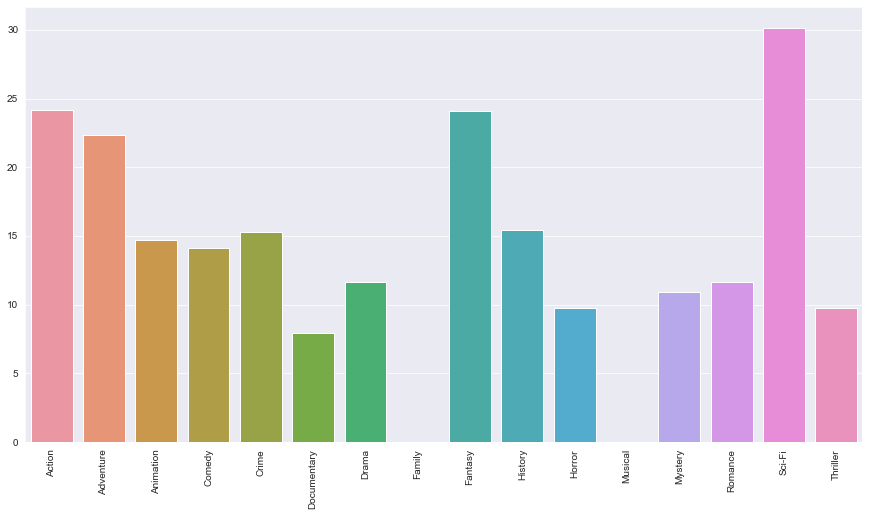

In [130]:
get_barplot('popularity')



In [12]:
#remove temporary files
con.close()
shutil.rmtree('temp/')